# **Data Preparation**

# 0.0. Imports

In [65]:
import pandas                                                           as pd
import numpy                                                            as np
import seaborn                                                          as sns
import matplotlib.pyplot                                                as plt
import pickle

from tabulate                       import tabulate
from scipy                          import stats                        as st
from sklearn                        import ensemble                     as en
from sklearn                        import model_selection              as ms
from sklearn                        import preprocessing                as pp
from sklearn                        import feature_selection            as fs
from sklearn                        import tree                         as tr
from boruta                         import BorutaPy

from sklearn.ensemble               import RandomForestRegressor

from IPython.core.display           import HTML
from IPython.display                import Image

import warnings
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [66]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20,12]
    plt.rcParams['font.size'] = 20
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    
    display(HTML ('<style>.container {width: 80% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    palette = ["#856088","#7BA05B", "#7BAFD4", "#FFC40C", "#B53389"]
    colors = sns.color_palette(palette=palette)
    sns.set_palette(colors)
    
jupyter_settings()
    

def one_bar_chart(df, coluna):
    g1 = round((df[[coluna]].value_counts(normalize=True)*100),2).reset_index().rename(columns = {0: 'total'});
    ax = sns.barplot(x=coluna, y='total', data=g1);
    sns.despine(offset=10, trim=True);

#    Add percentage values above each bar
    for p in ax.patches:
        height = p.get_height();
        text = ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{height:.2f}%', 
                       ha='center', fontweight='bold', fontsize=12);
    return ax, text

def two_bar_chart(df,coluna, axn):
    g1 = round((df[[coluna, 'response']].value_counts(normalize=True)*100),2).reset_index().rename(columns = {0: 'total'});
    ax = sns.barplot(x=coluna, y='total', data=g1, hue='response', ax=axn);

    # Add percentage values above each bar
    for p in ax.patches:
        height = p.get_height()
        text = ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{height:.2f}%', 
                       ha='center', fontweight='bold', fontsize=12);
    return ax, text

def histplot (df, coluna, label):
    
    if label == 0:
        h1 = df.loc[df['response'] == 0, coluna]
        fig = sns.histplot(h1);

    else:
        h2 = df.loc[df['response'] == 1, coluna]
        fig = sns.histplot(h2);
    return fig

def crosstable_graph(df, coluna, normalize, axn):
    ct = pd.crosstab(df[coluna], df['response'], normalize=normalize).mul(100).round(2)
    ax = ct.plot(kind='bar', stacked=True, rot=0, ax=axn)
    legend = ax.legend(title='response', bbox_to_anchor=(1, 1.02), loc='upper left')

    # iterate through each bar container
    for c in ax.containers:
        text = ax.bar_label(c, fmt='%0.2f%%', label_type='center', fontweight='bold', fontsize=12)
    return ax, legend, text

def cramer_v(x , y):
    cm = pd.crosstab (x , y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = st.chi2_contingency (cm) [0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n -1) )

    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt ( (chi2corr / n) / (min (kcorr - 1, rcorr - 1) ) )

## 0.2. Loading Data

In [67]:
df3 = pd.read_csv('../data/interim/df3_data_description_done.csv')

# 4.0. Exploratory Data Analysis

In [68]:
df4 = df3.copy()

Variable | Definition
-------- | -----------
id | Unique ID for the customer
gender	| Gender of the customer
age	| Age of the customer
driving_license | 0 : Customer does not have DL, 1 : Customer already has DL
region_code	| Unique code for the region of the customer
previously_insured	| 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
vehicle_age	| Age of the Vehicle
vehicle_damage	| 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
annual_premium	| The amount customer needs to pay as premium in the year
policy_sales_channel	| Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
days_associated| Number of Days, Customer has been associated with the company
response | 1 : Customer is interested, 0 : Customer is not interested

## 4.1. Análise Univariada

### 4.1.1 Response Variable

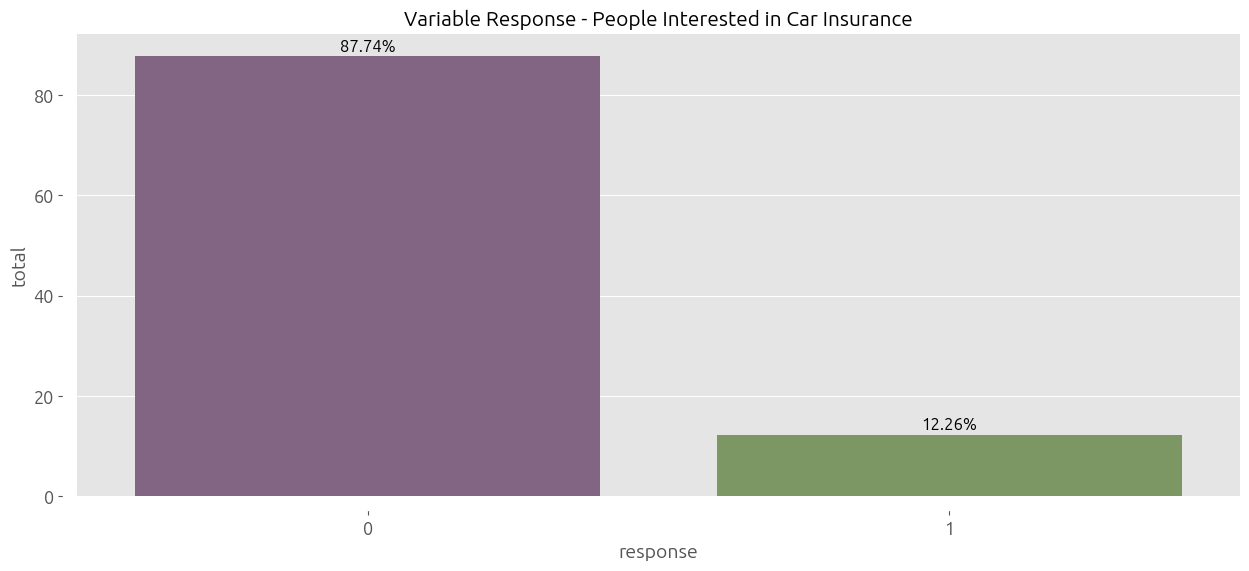

In [69]:
plt.figure(figsize=[15,6])
one_bar_chart(df4, 'response')
plt.title('Variable Response - People Interested in Car Insurance');

### 4.1.2. Numerical Variable

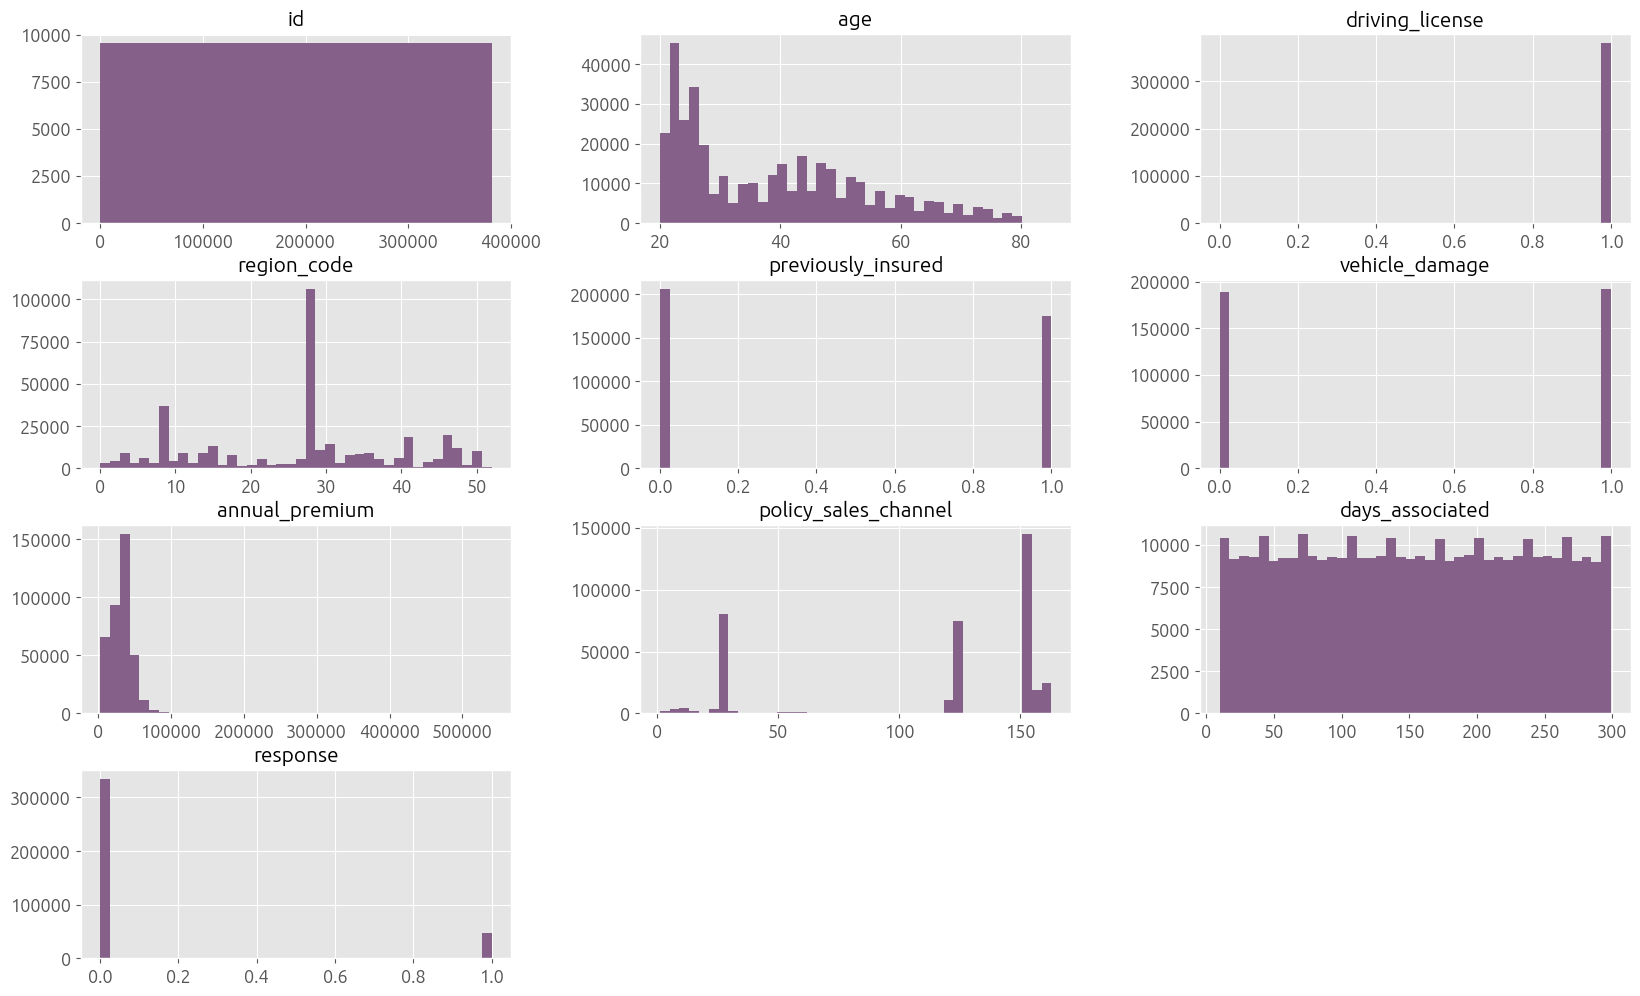

In [70]:
num_attributes = df4.select_dtypes (include = ['int64', 'float64']);
num_attributes.hist( bins = 40);

### 4.1.3. Categorical Variable

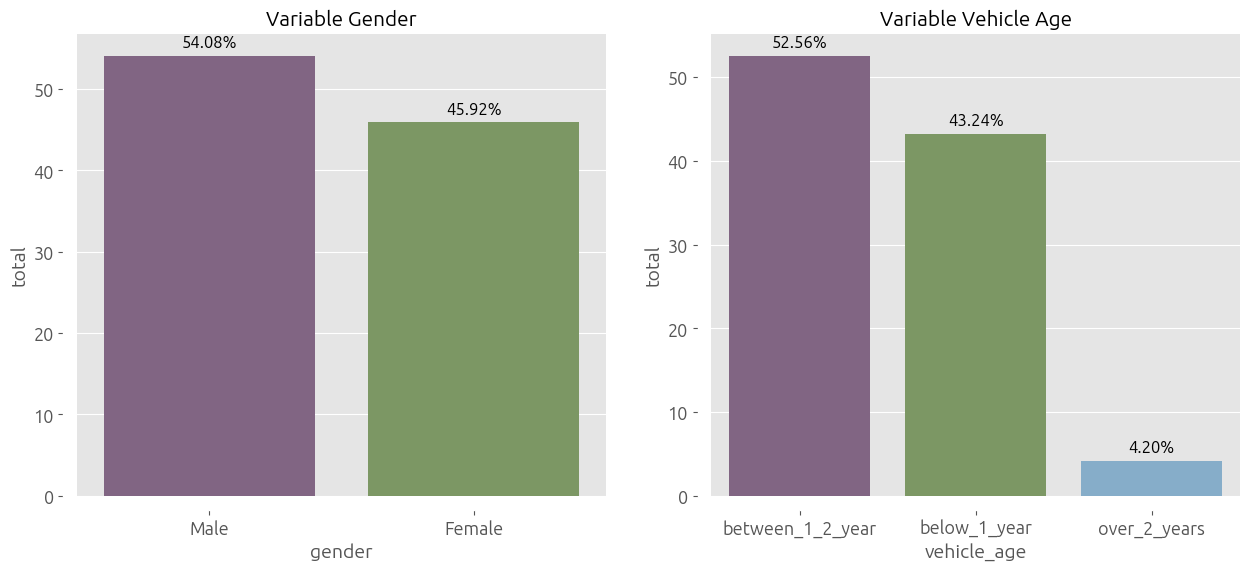

In [71]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
one_bar_chart(df4, 'gender');
plt.title('Variable Gender');
sns.despine(offset=10, trim=True)

plt.subplot(1,2,2)
one_bar_chart(df4, 'vehicle_age');
plt.title('Variable Vehicle Age');


## 4.2. Análise Bivariada

##### ***H1- Os clientes mais interessados em contratar um seguro automóvel são as mulheres***
Falsa - Os homens têm mais interesse em adquirir o seguro 

#####  ***H2 - Os clientes menos interessados em contratar um seguro automóvel são os que não possuem carteira de habilitação***
Verdadeira - Os mais interessado são clientes que possuem carteira de habilitação

#####  ***H3 - O canal mais utilizado é o canal com mais clientes interessados em comprar o seguro automóvel***
Falsa - O canal 152 é o mais usado, porém é por meio dele que os clientes mais rejeitam a oferta. Enquanto os canais 26 e 124, são os mais efetivos na prospecção

<Figure size 1500x500 with 0 Axes>

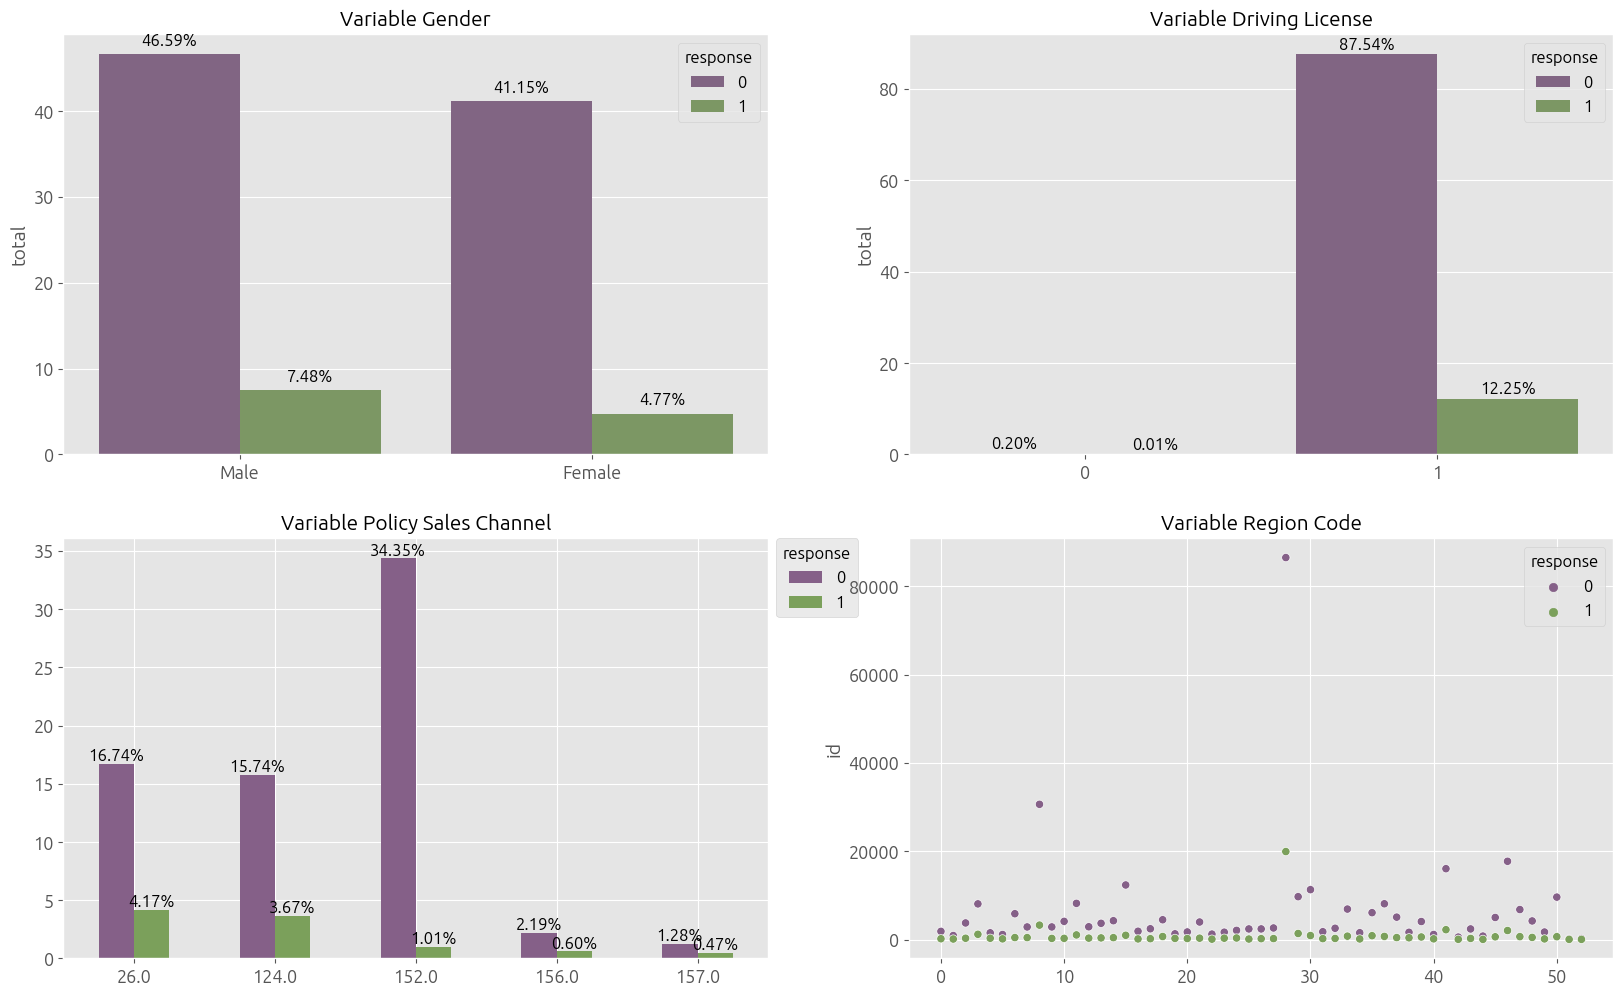

In [72]:
plt.figure(figsize=(15,5));
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);

two_bar_chart(df4,'gender', ax1);
ax1.set(xlabel=None);
ax1.set_title("Variable Gender");

two_bar_chart(df4,'driving_license', ax2);
ax2.set(xlabel=None);
ax2.set_title("Variable Driving License");

ct = pd.crosstab(df4['policy_sales_channel'], df4['response'], normalize='all').mul(100).round(2);
ct = ct.sort_values(1, ascending=False).head(5);
ax = ct.plot(kind='bar', rot=0, ax=ax3);
legend = ax.legend(title='response', bbox_to_anchor=(1, 1.02), loc='upper left');
for c in ax.containers:
    text = ax.bar_label(c, fmt='%0.2f%%', label_type='edge', fontweight='bold', fontsize=12);
ax3.set(xlabel=None);
ax3.set_title("Variable Policy Sales Channel");


rc = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index();
ax = sns.scatterplot(x='region_code', y='id', hue='response', data=rc, ax=ax4);
ax4.set(xlabel=None);
ax4.set_title('Variable Region Code');

##### ***H4 - Os clientes mais interessados em contratar um seguro automóvel são os com mais idade***
Verdadeira - Clientes com idade entre 36 - 55 anos desejam ter um seguro

#####  ***H5 - Os clientes mais interessados em comprar um seguro automóvel são os que têm mais dias associados***
Falsa - Clientes com mais dias associados recusaram a oferta

#####  ***H6 - Os clientes menos interessados em contratar um seguro automóvel são os que pagam mais de ₹30.000 no seguro saúde***
Verdadeira - Clientes que pagam mais de ₹30.000 não mostraram interesse

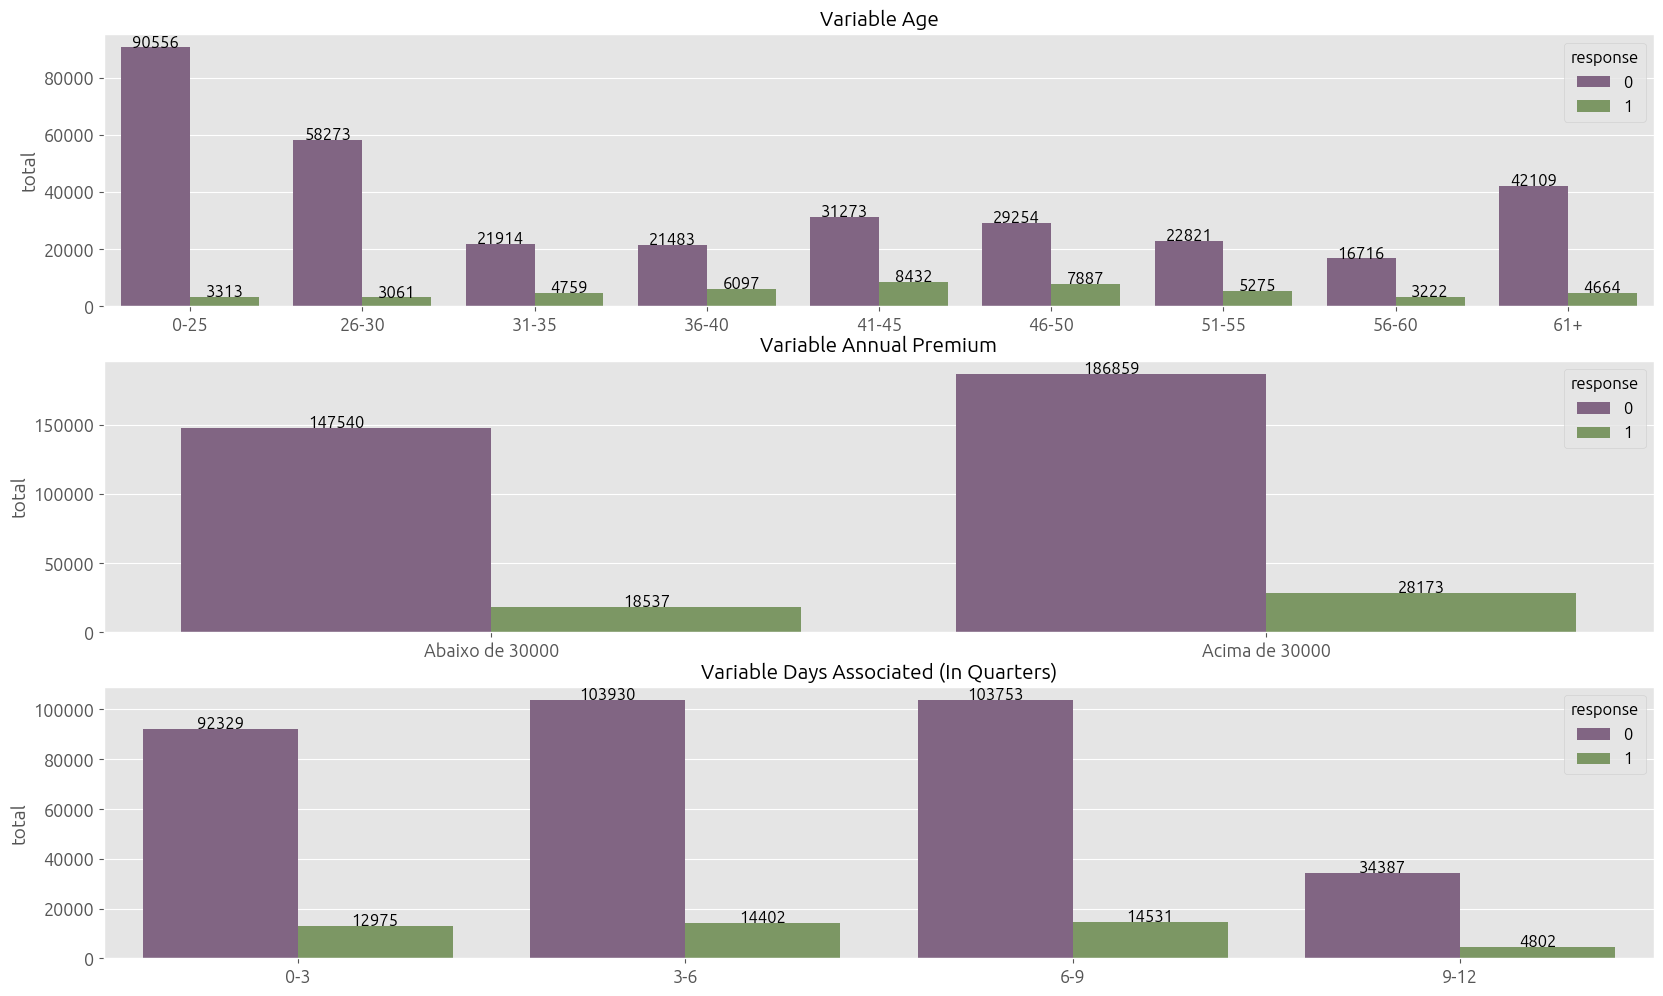

In [119]:
plt.subplot (3,1,1)
# age
age = df4.copy()
age['age_group'] = pd.cut(age['age'], bins=[0, 25, 30, 35, 40, 45, 50, 55, 60, 100], labels=['0-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61+'], right=False)

age_group = age[['age_group',  'response']].value_counts().reset_index().rename(columns = {0: 'total'}).dropna();

ax = sns.barplot (x='age_group', y='total', hue= 'response', data=age_group);

for p in ax.patches:
    height = p.get_height()
    text = ax.text(p.get_x() + p.get_width() / 2, height + 1, int(height),
                   ha='center', fontweight='bold', fontsize=12)
plt.title('Variable Age');
ax.set(xlabel=None);

plt.subplot (3,1,2)
# annual_premium
ap = df4.copy()
bins = [0, 30000, float('inf')]
labels = ['Abaixo de 30000', 'Acima de 30000']
ap['premium_group'] = pd.cut(ap['annual_premium'], bins=bins, labels=labels)

ap_group = ap[['premium_group',  'response']].value_counts().reset_index().rename(columns = {0: 'total'}).dropna();

ax = sns.barplot (x='premium_group', y='total', hue= 'response', data=ap_group);

for p in ax.patches:
    height = p.get_height()
    text = ax.text(p.get_x() + p.get_width() / 2, height + 1, int(height),
                   ha='center', fontweight='bold', fontsize=12)
plt.title('Variable Annual Premium');
ax.set(xlabel=None);

plt.subplot(3,1,3)
# dias
dias_a = df4.copy()
bins = [0, 90, 180, 270, 365]  
quarters = ['0-3', '3-6', '6-9', '9-12'] 
dias_a['quarters_current_contract'] = pd.cut(dias_a['days_associated'], bins=bins, labels=quarters, right=False)
dias = dias_a[['quarters_current_contract',  'response']].value_counts().reset_index().rename(columns = {0: 'total'}).dropna();

ax = sns.barplot (x='quarters_current_contract', y='total', hue= 'response', data=dias);

for p in ax.patches:
    height = p.get_height()
    text = ax.text(p.get_x() + p.get_width() / 2, height + 1, int(height),
                   ha='center', fontweight='bold', fontsize=12)
plt.title('Variable Days Associated (In Quarters)');
ax.set(xlabel=None);

##### ***H6 - Os clientes menos interessados em contratar um seguro automóvel são os que já possuem seguro automóvel***
Verdadeira - Os clientes que já pagam por um seguro automóvel mostraram desinteresse pela oferta.

##### ***H7- Os clientes mais interessados em contratar um seguro automóvel são o que possuem um modelo novo***
Falsa - Clientes que possuem modelos de veículos de 1 a 2 anos, têm mais interesse em adquirir o seguro 

##### ***H8 - Os clientes mais interessados em contratar um seguro automóvel são os que possuem um histórico de danos ao veículo***
Verdadeira - Clientes que já tiveram seus veículos danificados, mostraram interesse em adquirir o seguro

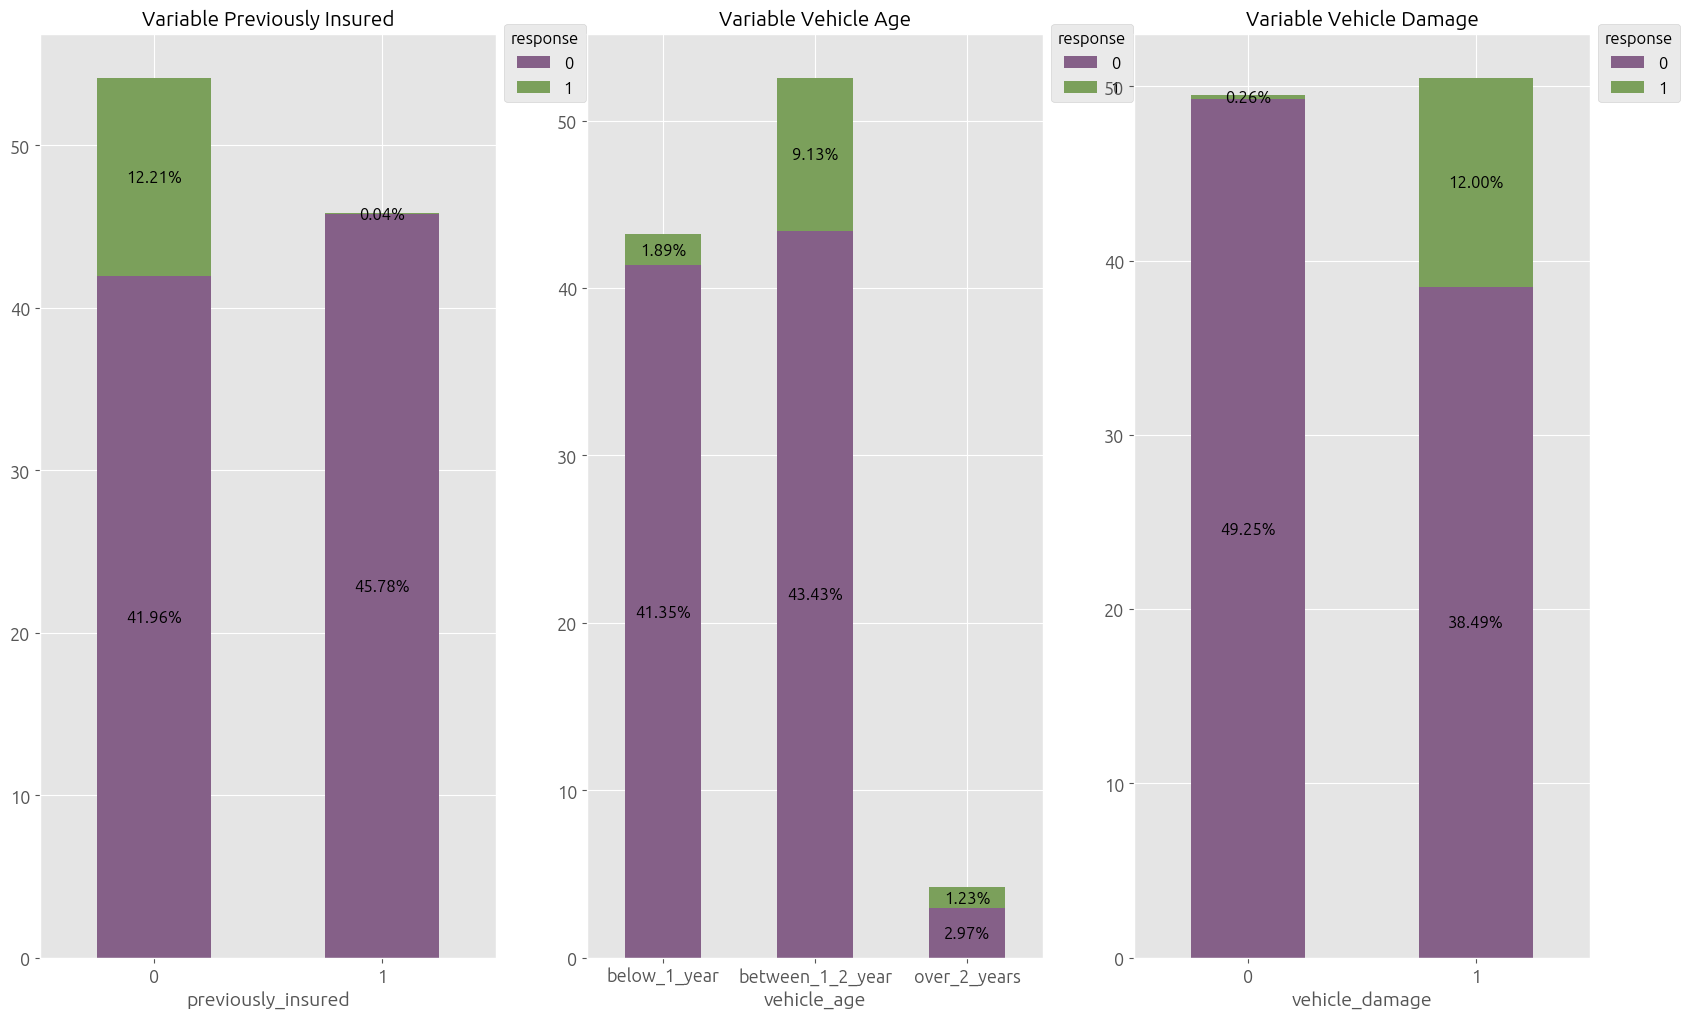

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

crosstable_graph(df4, 'previously_insured', 'all', ax1)
ax1.set_title("Variable Previously Insured");


crosstable_graph(df4, 'vehicle_age', 'all', ax2)
ax2.set_title("Variable Vehicle Age");


crosstable_graph(df4, 'vehicle_damage', 'all', ax3)
ax3.set_title("Variable Vehicle Damage");



### 4.2.1. Summary of Hypotheses

In [111]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
#Os clientes mais interessados em contratar um seguro automóvel são as mulheres
       ['H1', 'Falsa', 'Baixa'],
#Os clientes menos interessados em contratar um seguro automóvel são os que não possuem carteira de habilitação
       ['H2', 'Verdadeira', 'Baixa'],
#O canal mais utilizado é o canal com mais clientes interessados em comprar o seguro automóvel
       ['H3', 'Falsa', 'Baixa'],
#Os clientes mais interessados em contratar um seguro automóvel são os com mais idade
       ['H4', 'Verdadeira', 'Alta'],
#Os clientes mais interessados em comprar um seguro automóvel são os que têm mais dias associados
       ['H5', 'Falsa', 'Baixa'],
#Os clientes menos interessados em contratar um seguro automóvel são os que pagam mais de ₹30.000 no seguro saúde
       ['H6', 'Verdadeira', 'Média'],
#Os clientes menos interessados em contratar um seguro automóvel são os que já possuem seguro automóvel
       ['H7', 'Verdadeira', 'Media'],
#Os clientes mais interessados em contratar um seguro automóvel são o que possuem um modelo mais novo
       ['H8', 'Falsa', 'Alta'],
#Os clientes mais interessados em contratar um seguro automóvel são os que possuem um histórico de danos ao veículo
       ['H9', 'Verdadeira', 'Alta']]

print(tabulate (tab, headers= 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Verdadeira   Baixa
H3           Falsa        Baixa
H4           Verdadeira   Alta
H5           Falsa        Baixa
H6           Verdadeira   Média
H7           Verdadeira   Media
H8           Falsa        Alta
H9           Verdadeira   Alta


## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

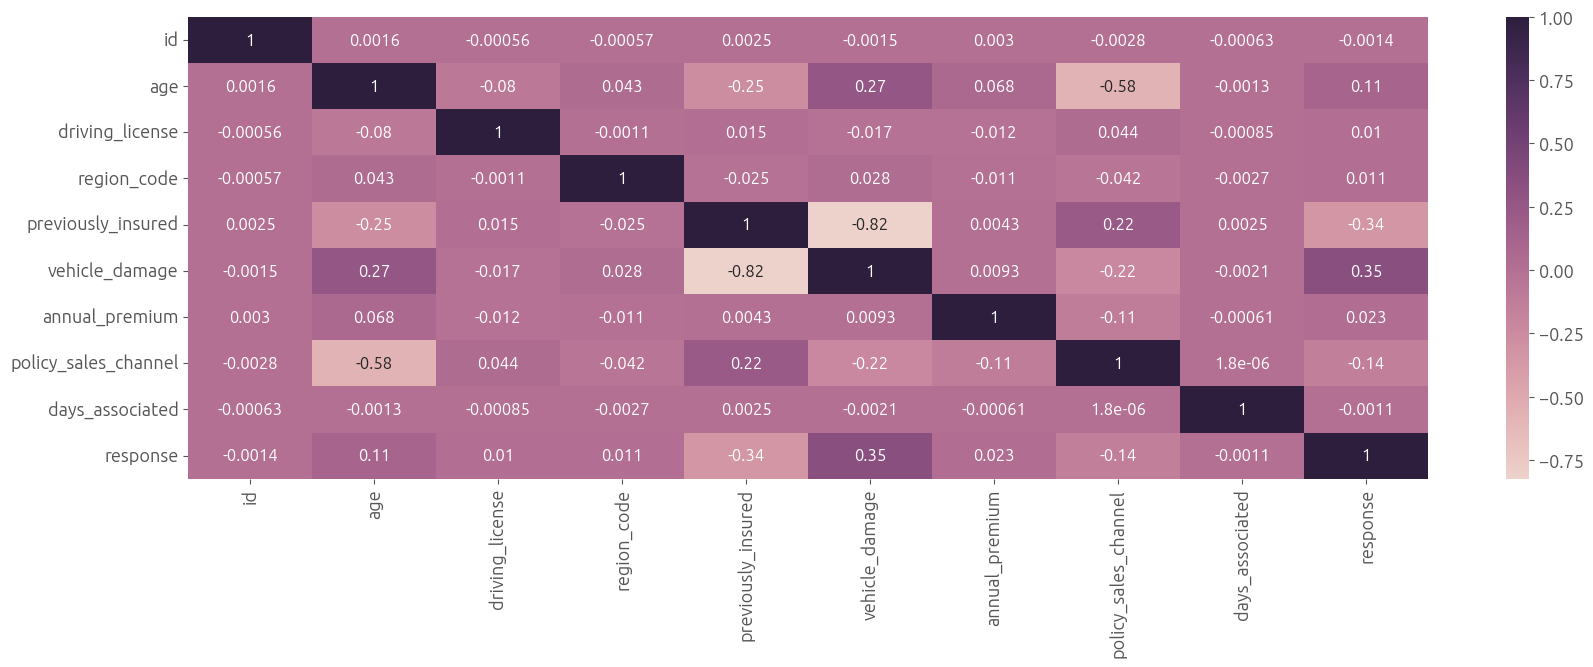

In [122]:
plt.figure(figsize=[20,6])
correlation = num_attributes.corr(method= 'pearson')
sns.heatmap(correlation, annot=True, cmap=sns.cubehelix_palette(as_cmap=True));

### 4.3.2. Categorical Attributes

In [125]:
a = df4.select_dtypes(include= 'object')

In [126]:
a.head(1)

,gender,vehicle_age
0,Male,over_2_years


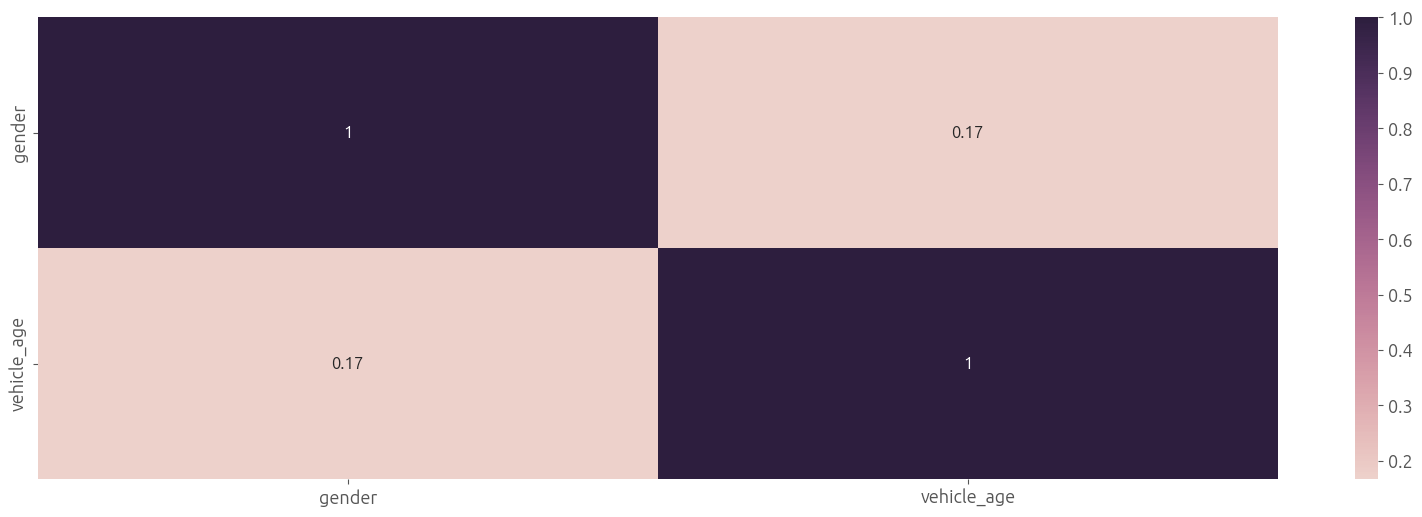

In [127]:
#calculate cramer V
plt.figure(figsize=[20,6])

a1 = cramer_v(a['gender'] , a['gender'])
a2 = cramer_v(a['gender'] , a['vehicle_age'])

a3 = cramer_v(a['vehicle_age'] , a['gender'])
a4 = cramer_v(a['vehicle_age'] , a['vehicle_age'])

#final dataset
d= pd.DataFrame ({'gender': [a1, a2],
                  'vehicle_age': [a3, a4]})

#final dataset
d = d.set_index(d.columns)
sns.heatmap(d, annot=True, cmap=sns.cubehelix_palette(as_cmap=True));

# 5.0. Data Preparation


In [32]:
train = pd.read_csv('../data/interim/train_feature_engineering.csv')
validation = pd.read_csv('../data/interim/validation_feature_engineering.csv')
test = pd.read_csv('../data/interim/test_feature_engineering.csv')

In [33]:
train.shape, validation.shape, test.shape

((243909, 12), (76222, 12), (60978, 12))

## 5.1. Train Preparation

In [34]:
train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_associated,response
0,330442,Male,53,1,13.0,0,between_1_2_year,1,30433.0,124.0,228,0
1,35893,Female,49,1,31.0,0,over_2_years,1,2630.0,124.0,206,0
2,215238,Male,49,1,45.0,0,between_1_2_year,1,31853.0,26.0,99,0
3,321916,Male,24,1,11.0,1,below_1_year,0,32043.0,152.0,27,0
4,182127,Female,31,1,41.0,0,below_1_year,1,30632.0,154.0,282,0


### 5.1.1. Standardization

In [35]:
ss_annual_premium = pp.StandardScaler()

# annual_premium
train['annual_premium'] = ss_annual_premium.fit_transform(train[['annual_premium']].values)


pickle.dump(ss_annual_premium, open('../src/features/annual_premium_scaler.pkl', 'wb'))

### 5.1.2. Rescaling

In [36]:
mms_age = pp.MinMaxScaler()
mms_days_associated = pp.MinMaxScaler()

# age - distribuicao Poison (concentracao nos numeros menores ) == 0 e normal == 1
train['age'] = mms_age.fit_transform(train[['age']].values)

# days_associated
train['days_associated'] = mms_days_associated.fit_transform(train[['days_associated']].values)

pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))
pickle.dump(mms_days_associated, open('../src/features/days_associated_scaler.pkl', 'wb'))

### 5.1.3 Transformação

#### 5.1.3.1 Enconding

In [37]:
# gender
target_encoder_gender = train.groupby('gender')['response'].mean()
train.loc[:,'gender'] = train['gender'].map(target_encoder_gender)

# region_code - Frequency Enconding / Target Enconding / Weighted Target Enconding
fe_region_code = train.groupby('region_code').size() / len(train)
train.loc[:,'region_code'] = train['region_code'].map(fe_region_code)

# vehicle_age - One Hot Enconding / Order Enconding / Frequency Enconding
fe_vehicle_age = train.groupby('vehicle_age').size() / len(train)
train.loc[:,'vehicle_age'] = train['vehicle_age'].map(fe_vehicle_age)

# policy_sales_channel - Target Enconding / Frequency Enconding
fe_policy_sales_channel = train.groupby('policy_sales_channel').size() / len(train)
train.loc[:,'policy_sales_channel'] = train['policy_sales_channel'].map(fe_policy_sales_channel)

pickle.dump(target_encoder_gender, open('../src/features/target_encoder_gender.pkl', 'wb'))
pickle.dump(fe_region_code , open('../src/features/fe_region_code.pkl', 'wb'))
pickle.dump(fe_vehicle_age , open('../src/features/fe_vehicle_age.pkl', 'wb'))
pickle.dump(fe_policy_sales_channel , open('../src/features/fe_policy_sales_channel.pkl', 'wb'))

In [38]:
train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_associated,response
0,330442,0.138012,0.507692,1,0.010697,0,0.525126,1,-0.007384,0.193929,0.754325,0
1,35893,0.103366,0.446154,1,0.005186,0,0.042085,1,-1.632807,0.193929,0.678201,0
2,215238,0.138012,0.446154,1,0.014838,0,0.525126,1,0.075632,0.208385,0.307958,0
3,321916,0.138012,0.061538,1,0.023775,1,0.432788,0,0.086740,0.353972,0.058824,0
4,182127,0.103366,0.169231,1,0.047522,0,0.432788,1,0.004249,0.015727,0.941176,0


## 5.2.  Validation Preparation

In [39]:
# annual_premium
validation['annual_premium'] = ss_annual_premium.fit_transform(validation[['annual_premium']].values)

# age 
validation['age'] = mms_age.fit_transform(validation[['age']].values)

# days_associated
validation['days_associated'] = mms_days_associated.fit_transform(validation[['days_associated']].values)

# gender
target_encoder_gender = validation.groupby('gender')['response'].mean()
validation.loc[:,'gender'] = validation['gender'].map(target_encoder_gender)

# region_code
fe_region_code = validation.groupby('region_code').size() / len(validation)
validation.loc[:,'region_code'] = validation['region_code'].map(fe_region_code)

# vehicle_age
fe_vehicle_age = validation.groupby('vehicle_age').size() / len(validation)
validation.loc[:,'vehicle_age'] = validation['vehicle_age'].map(fe_vehicle_age)

# policy_sales_channel - Target Enconding / Frequency Enconding
fe_policy_sales_channel = validation.groupby('policy_sales_channel').size() / len(validation)
validation.loc[:,'policy_sales_channel'] = validation['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
validation = validation.fillna(0)


In [40]:
validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_associated,response
0,179402,0.105247,0.630769,1,0.280680,0,0.526751,1,0.059658,0.194183,0.231834,0
1,110750,0.138884,0.584615,1,0.088820,1,0.526751,0,0.316210,0.194183,0.747405,0
2,192903,0.138884,0.476923,1,0.280680,0,0.526751,1,-0.028555,0.002034,0.709343,0
3,188632,0.138884,0.415385,1,0.004434,0,0.526751,1,0.085047,0.007452,0.595156,0
4,7520,0.105247,0.015385,1,0.027918,0,0.431490,1,0.555514,0.352733,0.903114,0


## 5.3.  Test Preparation

In [41]:
# annual_premium
test['annual_premium'] = ss_annual_premium.fit_transform(test[['annual_premium']].values)

# age 
test['age'] = mms_age.fit_transform(test[['age']].values)

# days_associated
test['days_associated'] = mms_days_associated.fit_transform(test[['days_associated']].values)

# gender
target_encoder_gender = test.groupby('gender')['response'].mean()
test.loc[:,'gender'] = test['gender'].map(target_encoder_gender)

# region_code
fe_region_code = test.groupby('region_code').size() / len(test)
test.loc[:,'region_code'] = test['region_code'].map(fe_region_code)

# vehicle_age
fe_vehicle_age = test.groupby('vehicle_age').size() / len(test)
test.loc[:,'vehicle_age'] = test['vehicle_age'].map(fe_vehicle_age)

# policy_sales_channel - Target Enconding / Frequency Enconding
fe_policy_sales_channel = test.groupby('policy_sales_channel').size() / len(test)
test.loc[:,'policy_sales_channel'] = test['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
test = test.fillna(0)


In [42]:
test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_associated,response
0,138265,0.139414,0.338462,1,0.021893,0,0.526141,1,-1.639640,0.026387,0.858131,0
1,273548,0.139414,0.384615,1,0.034799,0,0.526141,1,-0.002814,0.211355,0.913495,1
2,256446,0.104367,0.384615,1,0.028469,0,0.526141,1,-0.555854,0.014759,0.463668,0
3,139601,0.139414,0.446154,1,0.051773,1,0.526141,0,-0.066349,0.211355,0.449827,0
4,13805,0.139414,0.215385,1,0.279330,0,0.526141,0,1.296392,0.195038,0.536332,0


In [43]:
train.to_csv('../data/interim/train_enconding.csv', index=False)
validation.to_csv('../data/interim/validation_enconding.csv', index=False)
test.to_csv('../data/interim/test_enconding.csv', index=False)

# 6.0. Feature Selection

In [44]:
df6 = train.copy()

In [45]:
df6.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_associated,response
0,330442,0.138012,0.507692,1,0.010697,0,0.525126,1,-0.007384,0.193929,0.754325,0
1,35893,0.103366,0.446154,1,0.005186,0,0.042085,1,-1.632807,0.193929,0.678201,0
2,215238,0.138012,0.446154,1,0.014838,0,0.525126,1,0.075632,0.208385,0.307958,0
3,321916,0.138012,0.061538,1,0.023775,1,0.432788,0,0.086740,0.353972,0.058824,0
4,182127,0.103366,0.169231,1,0.047522,0,0.432788,1,0.004249,0.015727,0.941176,0


## 6.1. Extra Trees Classifier as Feature Selector

In [46]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = df6['response'].values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                feature  importance
0       days_associated    0.277644
0        annual_premium    0.243942
0                   age    0.166710
0           region_code    0.100582
0        vehicle_damage    0.077317
0  policy_sales_channel    0.062095
0    previously_insured    0.053479
0           vehicle_age    0.012470
0                gender    0.005263
0       driving_license    0.000498


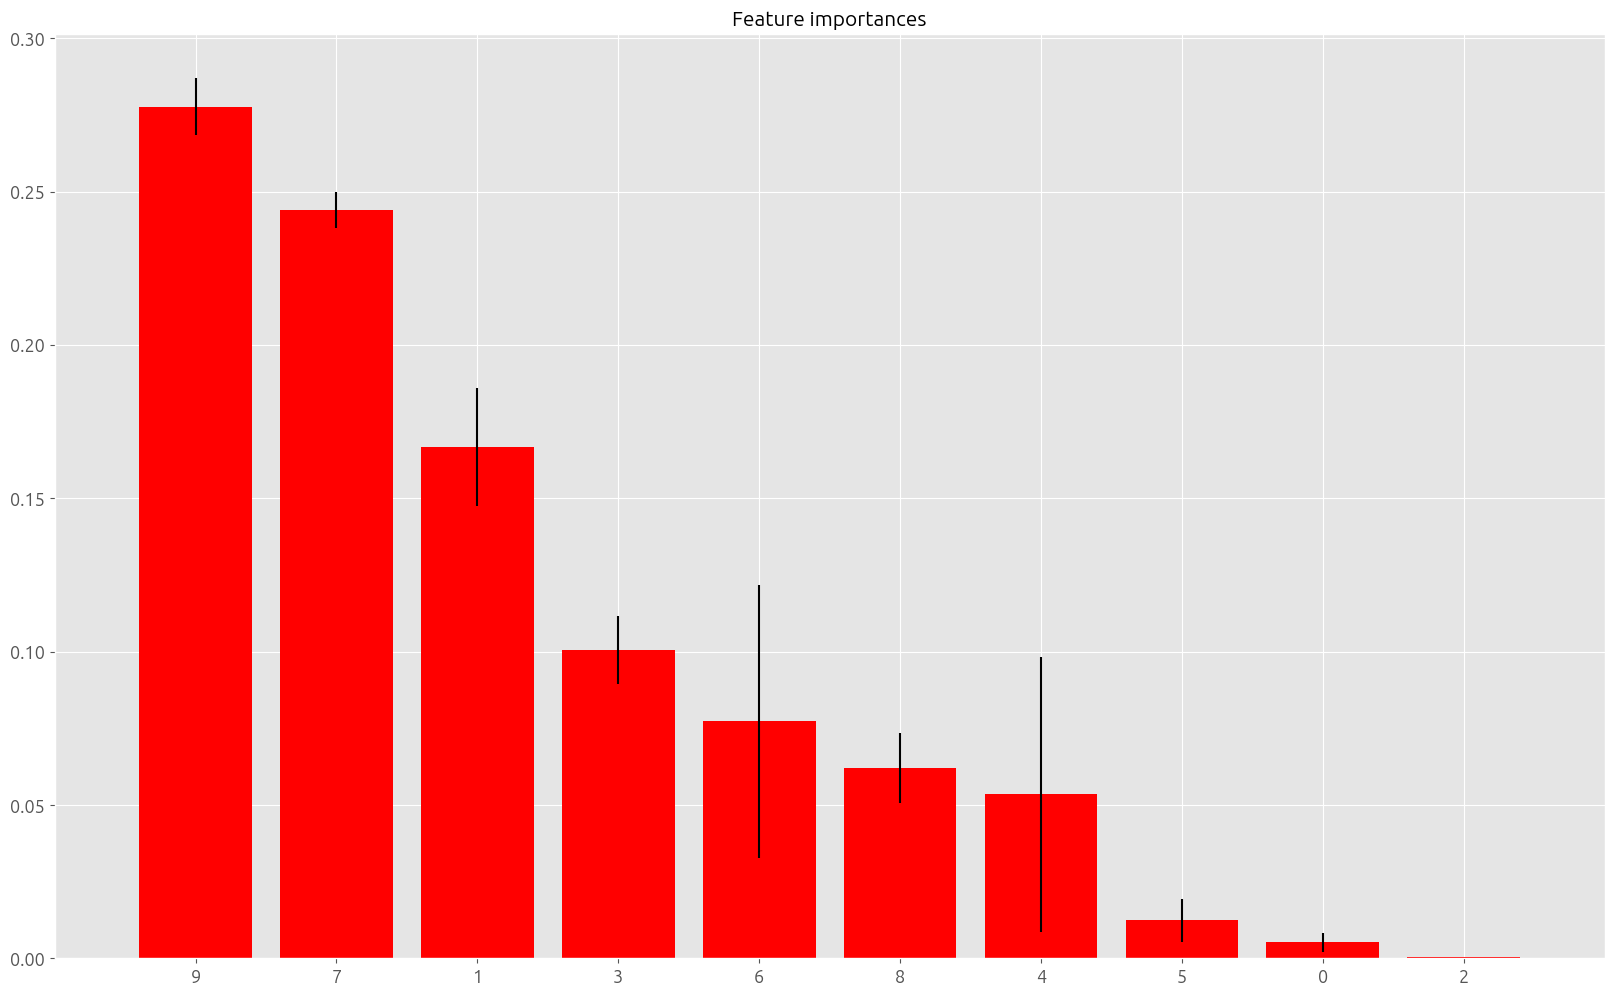

In [47]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# print the feature ranking
print('Feature Ranking:')

df_imp = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# plot the impurity - based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

## 6.2. Boruta as Feature Selector

In [48]:
# training and test dataset for Boruta

X_train_n = df6.drop(['id', 'response'], axis=1).values
y_train_n = df6['response'].values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor (n_estimators=100, max_depth=6, random_state=42, n_jobs = -1)

# define Boruta
boruta = BorutaPy (verbose=2,
    estimator= rf,
    n_estimators='auto',
    max_iter=10 ).fit(X_train_n, y_train_n)

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	7
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 10
Confirmed: 	7
Tentative: 	1
Rejected: 	2


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	0
Rejected: 	2


### 6.2.1. Best Features from Boruta

In [49]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = df6.drop(['id', 'response'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not_selected_boruta 
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [50]:
cols_selected_boruta

['age',
 'region_code',
 'previously_insured',
 'vehicle_age',
 'vehicle_damage',
 'annual_premium',
 'policy_sales_channel']

In [51]:
cols_not_selected_boruta 

['days_associated', 'driving_license', 'gender']

## 6.3. Lightgbm as Feature Selector

In [52]:
import lightgbm as lgb

# data preparation
X = df6.drop(['id', 'response'], axis=1)
y = df6['response'].values
data = lgb.Dataset(X, label=y)

# model definition
bst = lgb.train(params={"objective": "binary"},
                train_set=data,
                num_boost_round=10)

importance_df = (
    pd.DataFrame ({
        'feature_name': bst.feature_name(),
        'importance_gain': bst.feature_importance(importance_type='gain'),
        'importance_split': bst.feature_importance(importance_type='split')
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)

# lgb.plot_importance(bst)
print(importance_df)

[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742
           feature_name  importance_gain  importance_split
0        vehicle_damage    148572.097168                10
1                   age     28139.523163                70
2    previously_insured     20163.045731                26
3  policy_sales_channel      6239.529422               108
4           vehicle_age      1335.308000                25
5        annual_premium      1000.973089                23
6           region_code  